              Sources F_{0.88mm}(mJy) F_{2.87mm}(mJy)       \alpha  \
0   J15530132-2114135     5.78\pm0.14   0.603\pm0.039  1.91\pm0.03   
1   J15582981-2310077     5.86\pm0.18    0.58\pm0.029  1.96\pm0.02   
2   J15583692-2257153   174.92\pm0.27     5.18\pm0.26  2.98\pm0.04   
3   J16001844-2230114     3.89\pm0.15    0.36\pm0.031  2.01\pm0.04   
4   J16014086-2258103     3.45\pm0.14    0.28\pm0.034  2.12\pm0.06   
5   J16020757-2257467     5.26\pm0.27    0.49\pm0.061  2.01\pm0.06   
6   J16024152-2138245    10.25\pm0.19    1.08\pm0.068   1.9\pm0.04   
7   J16035767-2031055      4.3\pm0.39    0.41\pm0.034  1.99\pm0.01   
8   J16042165-2130284   218.76\pm0.81      5.94\pm0.3  3.05\pm0.04   
9   J16054540-2023088     7.64\pm0.15       1\pm0.044  1.72\pm0.02   
10  J16062196-1928445     4.08\pm0.52    0.65\pm0.042  1.55\pm0.05   
11  J16072625-2432079    13.12\pm0.24    1.08\pm0.069  2.11\pm0.04   
12  J16075796-2040087    23.49\pm0.12     2.37\pm0.14  1.94\pm0.04   
13  J16082324-193000

/Users/mauro/Library/CloudStorage/Dropbox/GitHub/Upper-Sco-2022/Table_2.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex('Table 2.tex', index=False, escape=False, longtable=True)


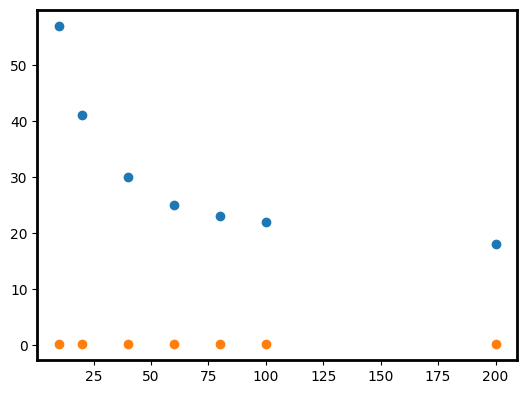

[-2, -3, 0, -9, -9, -7, -3, -46, 0, -2, -16, -2, -1, -5, -4, -2, 0, -7, -3, -8, -2, -2, -1, -3]


/Users/mauro/Library/CloudStorage/Dropbox/GitHub/Upper-Sco-2022/Table_3.py:103: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_3_pandas.to_latex('Table 3 pandas.tex', index=False, longtable=True, escape=False, column_format='lcccccc')


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from astropy import constants

from data_file import source_list_garrett, luminosity_list_barenfeld_updated, radius_dust_updated, lower_bound_radius_updated, upper_bound_radius_updated, flux_list_2_87mm_garrett, flux_barenfeld_0_88mm_updated, upper_sco
from Parallaxes import distances_updated_upper_sco
from Table_2 import surface_density_list
from Table_3 import opacity_list_3mm, opacity_list_0_87mm, temperature_list_van_der_plas


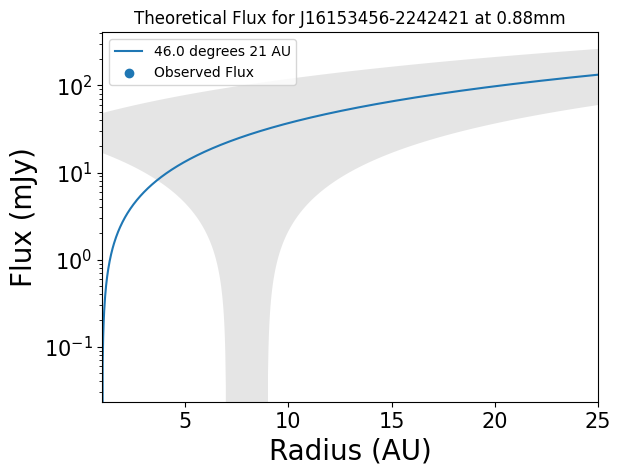

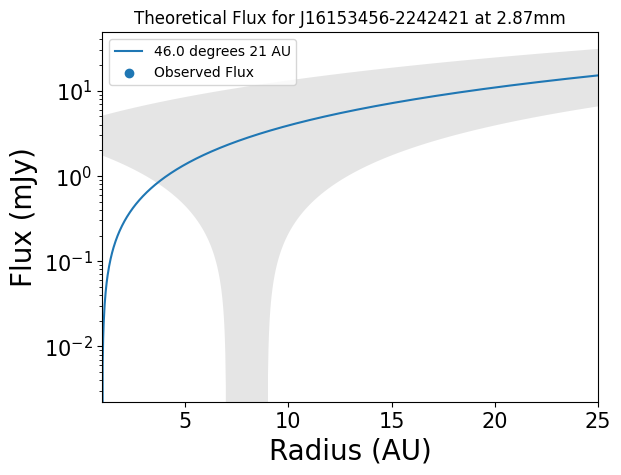

Flux at 21 AU: 104.6827271319801
Flux at 21 AU: 11.682934595732164


In [2]:

# All constants are in CGS units
wavelength_list = [0.088, 0.287]
c = constants.c.cgs.value
h = constants.h.cgs.value
k_b = constants.k_B.cgs.value
s_b = constants.sigma_sb.cgs.value
L_sun = constants.L_sun.cgs.value
c = constants.c.cgs.value

# Defining the star's name and finding its index in the data list
star_name = "J16141107-2305362"
index_star = source_list_garrett.index(star_name)


# Defining some values that can be changed to produce different results
flaring = 0.02
log_L_star = luminosity_list_barenfeld_updated[index_star]
L_star = (10 ** log_L_star) * L_sun
k_v_3mm = opacity_list_3mm[index_star]
k_v_0_87mm = opacity_list_0_87mm[index_star]
sur_den_0 = surface_density_list[index_star]

temperature_star = temperature_list_van_der_plas[index_star]
AU_in_cm = 1.5 * 10 ** 13
pc_in_cm = 3.086 * 10 ** 18
d = distances_updated_upper_sco[index_star] * pc_in_cm
R_in = 1 * AU_in_cm
R_out = radius_dust_updated[index_star] * AU_in_cm
R_out_list = np.linspace(1, 25, 1000) * AU_in_cm
R_out_lower_error = lower_bound_radius_updated[index_star] * AU_in_cm
R_out_upper_error = upper_bound_radius_updated[index_star] * AU_in_cm

# Defining the function to be integrated
function_to_integrate = lambda R, planck_function_wavelength: planck_function_wavelength * R


wavelength = 0.088
def planck_function_frequency(frequency, temperature):
    """
    Returns the Planck function at a given frequency and temperature.
    """
    exponent = h*frequency/(k_b*temperature)
    return 2*h*frequency**3/c**2 * 1/(np.exp(exponent)-1)

def integrated_planck_radius(R_in, R_out, temperature):
    """
    Integrates the Planck function multiplied by the radius from R_in to R_out.
    Returns the result in units of erg/s/cm^2.
    """
    function_to_integrate = lambda R, temperature: R*planck_function_frequency(c/wavelength, temperature)
    result, _ = quad(function_to_integrate, R_in, R_out, args=(temperature))
    return result

def passive_T(R, L_star, flaring=0.02):
    T = (flaring * L_star / (8 * np.pi * R ** 2 * s_b)) ** (1/4)
    return T

def final(i, d, R_in, R_out, L_star):
    """
    Calculates the flux from the dust at a given inclination angle (i).
    """
    theoretical_flux = 10 ** 26 * 2 * np.pi * np.cos(i) * integrated_planck_radius(R_in, R_out, passive_T(R_out, L_star, flaring=0.02)) / (d**2)
    return theoretical_flux

def spectral_index(flux_density_1, flux_density_2, wavelength_1, wavelength_2):
    numerator = np.log10(flux_density_2/flux_density_1)
    denominator = np.log10(wavelength_2/wavelength_1)
    return numerator/denominator


i = 46 * np.pi/180
i_lower_error = 21 * np.pi/180
i_upper_error = 12 * np.pi/180
# for i in radians from 'x' degrees i = x * np.pi/180
# for i in degrees from 'x' radians i = x * 180/np.pi

# Calculating the flux for the given inclination angle and radius
flux_values_0_88mm = []
flux_values_0_88mm_lower_error = []
flux_values_0_88mm_upper_error = []

flux_values_2_87mm = []
flux_values_2_87mm_lower_error = []
flux_values_2_87mm_upper_error = []

for radiuses in R_out_list:
    wavelength = 0.088
    flux_values_0_88mm.append(final(i, d, R_in, radiuses, L_star))
    flux_values_0_88mm_lower_error.append(final(i - i_lower_error, d, R_in, radiuses + R_out_upper_error, L_star))
    flux_values_0_88mm_upper_error.append(final(i + i_upper_error, d, R_in, radiuses + R_out_lower_error, L_star))
    wavelength = 0.287
    flux_values_2_87mm.append(final(i, d, R_in, radiuses, L_star))
    flux_values_2_87mm_lower_error.append(final(i - i_lower_error, d, R_in, radiuses + R_out_upper_error, L_star))
    flux_values_2_87mm_upper_error.append(final(i + i_upper_error, d, R_in, radiuses + R_out_lower_error, L_star))

i = i * 180/np.pi
i_lower_error = i_lower_error * 180/np.pi
i_upper_error = i_upper_error * 180/np.pi

if __name__ == '__main__':
    fig, ax = plt.subplots()
    plt.plot(R_out_list/AU_in_cm, flux_values_0_88mm, label= str(i) + " degrees " + str(21) + " AU")
    #plt.plot(R_out_list/AU_in_cm, flux_values_0_88mm_lower_error, label= str(i - i_lower_error) + " degrees " + str(21 + R_out_upper_error/AU_in_cm) + " AU")
    #plt.plot(R_out_list/AU_in_cm, flux_values_0_88mm_upper_error, label= str(i + i_upper_error) + " degrees " + str(21 + R_out_lower_error/AU_in_cm) + " AU")
    plt.fill_between(R_out_list/AU_in_cm, flux_values_0_88mm_lower_error, flux_values_0_88mm_upper_error, alpha=0.2, facecolor='gray')
    plt.scatter(radius_dust_updated[index_star], flux_barenfeld_0_88mm_updated[index_star], label='Observed Flux')
    plt.xlim(1,25)

    plt.title("Theoretical Flux for J16153456-2242421 at 0.88mm")
    plt.xlabel("Radius (AU)", fontsize=20), plt.ylabel("Flux (mJy)", fontsize=20)
    plt.legend()
    plt.yscale('log')
    plt.savefig('J16153456-2242421 theoretical and measured flux 0.88mm.png')
    ax.tick_params(which='both', labelsize=15)


    plt.show()

    fig, ax = plt.subplots()
    plt.plot(R_out_list/AU_in_cm, flux_values_2_87mm, label= str(i) + " degrees " + str(21) + " AU")
    #plt.plot(R_out_list/AU_in_cm, flux_values_2_87mm_lower_error, label= str(i - i_lower_error) + " degrees " + str(21 + R_out_upper_error/AU_in_cm) + " AU")
    #plt.plot(R_out_list/AU_in_cm, flux_values_2_87mm_upper_error, label= str(i + i_upper_error) + " degrees " + str(21 + R_out_lower_error/AU_in_cm) + " AU")
    plt.fill_between(R_out_list/AU_in_cm, flux_values_2_87mm_lower_error, flux_values_2_87mm_upper_error, alpha=0.2, facecolor='gray')
    plt.scatter(radius_dust_updated[index_star], flux_list_2_87mm_garrett[index_star], label='Observed Flux')
    plt.xlim(1,25)

    plt.title("Theoretical Flux for J16153456-2242421 at 2.87mm")
    plt.xlabel("Radius (AU)", fontsize=20), plt.ylabel("Flux (mJy)", fontsize=20)
    plt.legend()
    plt.yscale('log')
    plt.savefig('J16153456-2242421 theoretical and measured flux 2.87mm.png')
    ax.tick_params(which='both', labelsize=15)

    plt.show()


i = 46 * np.pi/180
wavelength = 0.088
flux_21AU_0_88mm = final(i, d, R_in, 21 * AU_in_cm, L_star)
print('Flux at 21 AU:', flux_21AU_0_88mm)
wavelength = 0.287
flux_21AU_2_87mm = final(i, d, R_in, 21 * AU_in_cm, L_star)
print('Flux at 21 AU:', flux_21AU_2_87mm)

In [3]:
print(round(flux_barenfeld_0_88mm_updated[index_star]/flux_21AU_0_88mm * 100, 2), '%')
print(round(flux_list_2_87mm_garrett[index_star]/flux_21AU_2_87mm * 100, 2), '%')

4.56 %
5.99 %


/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_13615/3271999098.py:51: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(function_to_integrate, R_in, R_out, args=(temperature))
/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_13615/3271999098.py:66: RuntimeWarning: invalid value encountered in double_scalars
  numerator = np.log10(flux_density_2/flux_density_1)


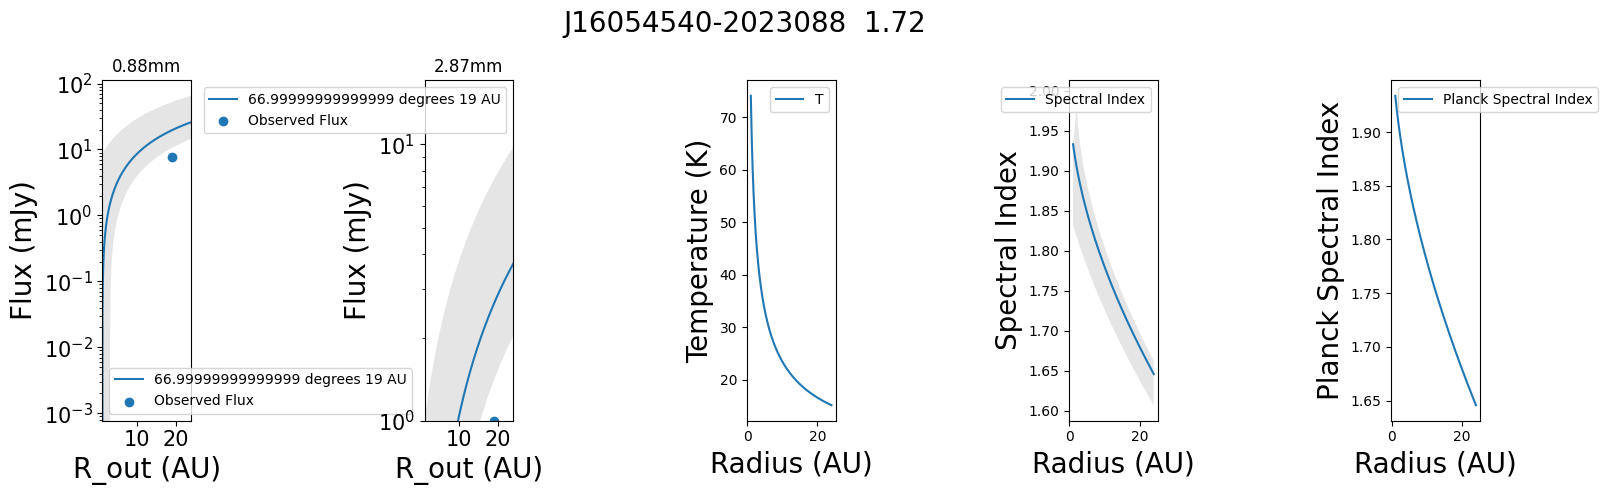

Flux 0.88mm at 21 AU: 19.547853832386714   39.083574419520744 %
Flux 2.87mm at 21 AU: 2.6563132029746597   37.64616306842712 %


/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_13615/3271999098.py:66: RuntimeWarning: invalid value encountered in double_scalars
  numerator = np.log10(flux_density_2/flux_density_1)


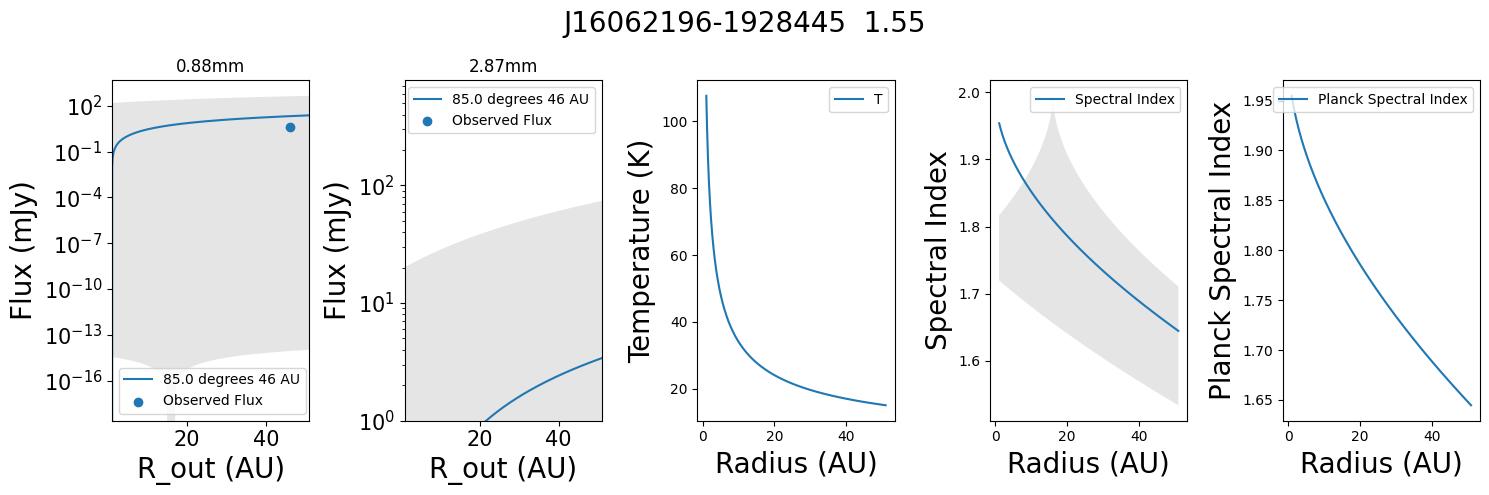

Flux 0.88mm at 21 AU: 21.059259875645587   19.373900241947247 %
Flux 2.87mm at 21 AU: 2.944291572810073   22.07661788671395 %


/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_13615/3271999098.py:51: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(function_to_integrate, R_in, R_out, args=(temperature))
/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_13615/3271999098.py:66: RuntimeWarning: invalid value encountered in double_scalars
  numerator = np.log10(flux_density_2/flux_density_1)
/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_13615/3271999098.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  T = (flaring * L_star / (8 * np.pi * R ** 2 * s_b)) ** (1/4)
/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_13615/3271999098.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*h*frequency**3/c**2 * 1/(np.exp(exponent)-1)


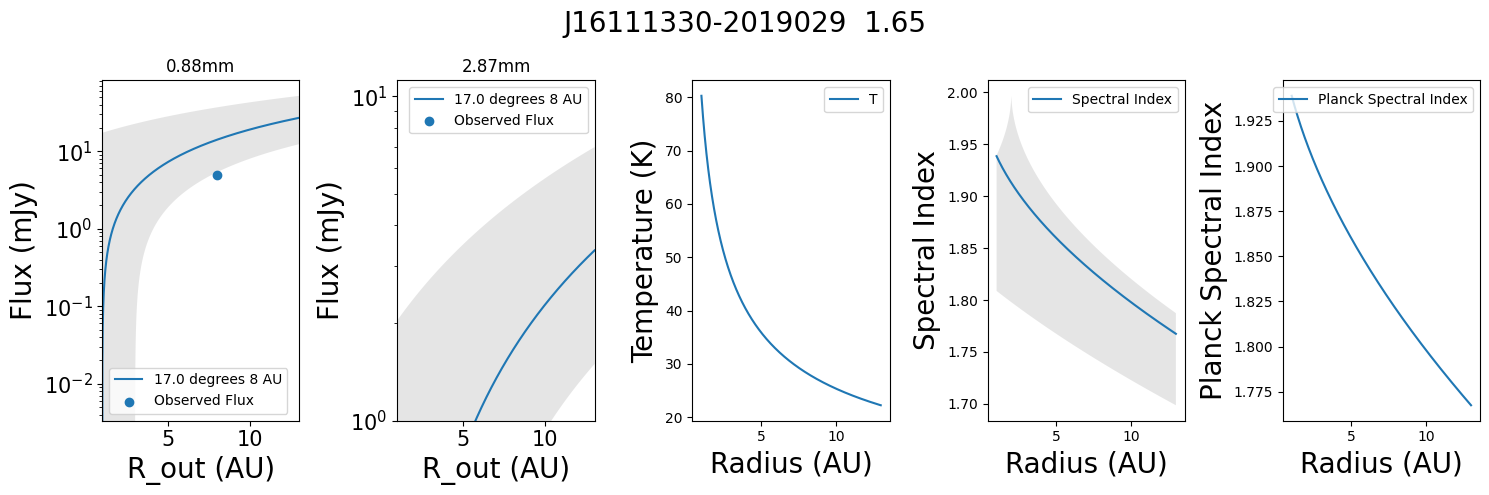

Flux 0.88mm at 21 AU: 14.12682071753215   34.54421980413226 %
Flux 2.87mm at 21 AU: 1.6422011232569178   42.016777983414606 %


/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_13615/3271999098.py:66: RuntimeWarning: invalid value encountered in double_scalars
  numerator = np.log10(flux_density_2/flux_density_1)


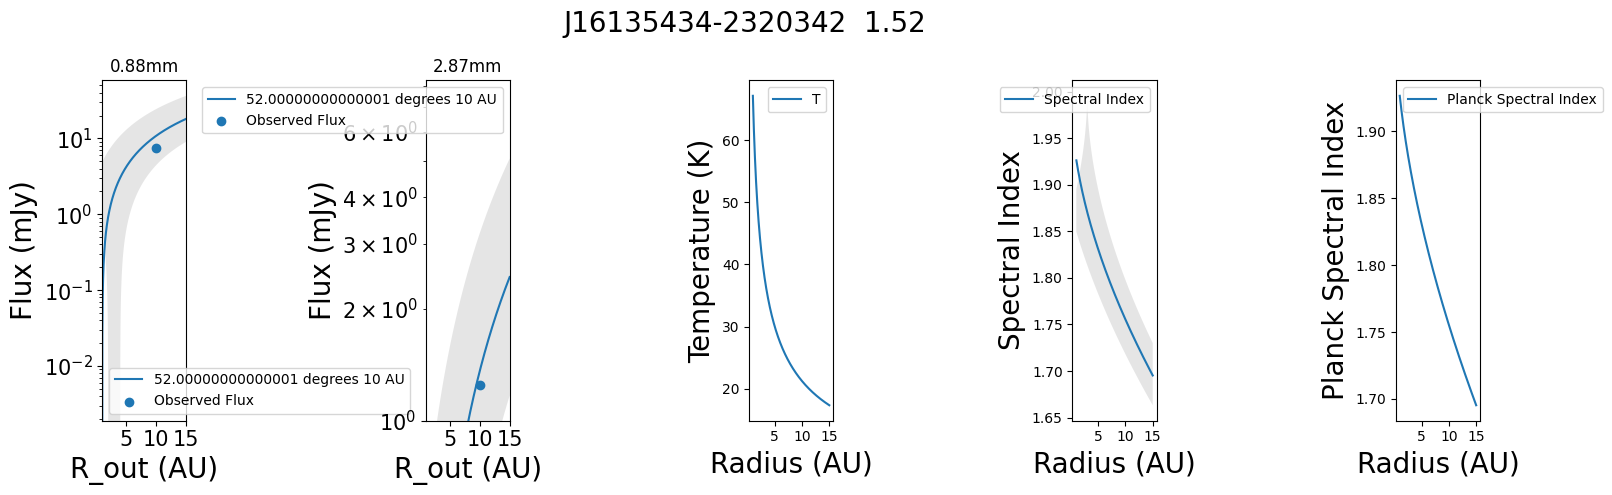

Flux 0.88mm at 21 AU: 10.815078262726573   69.6250162696615 %
Flux 2.87mm at 21 AU: 1.3578242290022955   92.05904367448777 %


/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_13615/3271999098.py:66: RuntimeWarning: invalid value encountered in double_scalars
  numerator = np.log10(flux_density_2/flux_density_1)


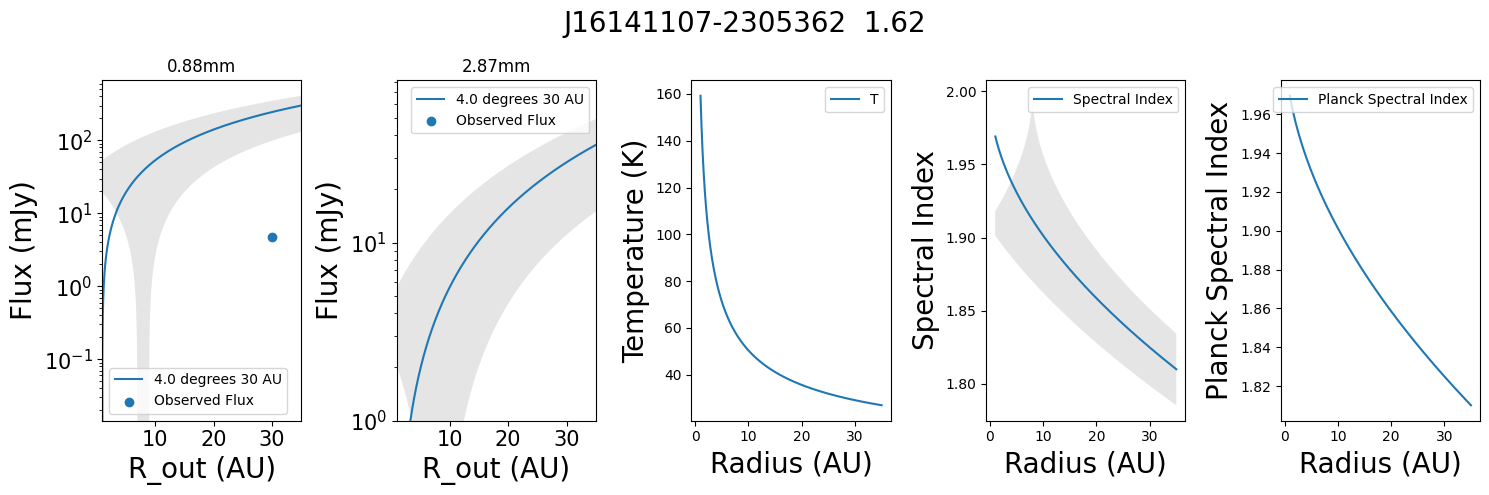

Flux 0.88mm at 21 AU: 244.47905814422396   1.9510873594686642 %
Flux 2.87mm at 21 AU: 28.26827258123565   2.4762744097234184 %


/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_13615/3271999098.py:51: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, _ = quad(function_to_integrate, R_in, R_out, args=(temperature))
/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_13615/3271999098.py:66: RuntimeWarning: invalid value encountered in double_scalars
  numerator = np.log10(flux_density_2/flux_density_1)
/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_13615/3271999098.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  T = (flaring * L_star / (8 * np.pi * R ** 2 * s_b)) ** (1/4)
/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_13615/3271999098.py:43: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*h*frequency**3/c**2 * 1/(np.exp(exponent)-1)


In [9]:
from data_file import inclination_list_barenfeld_updated, inclination_list_barenfeld_lower_error_updated, inclination_list_barenfeld_upper_error_updated, lower_bound_radius_updated, upper_bound_radius_updated

from Table_2 import spectral_index_upper_sco

for index, element in enumerate(source_list_garrett):
    theoretical_flux_0_88mm = []
    theoretical_flux_0_88mm_lower_error = []
    theoretical_flux_0_88mm_upper_error = []
    theoretical_flux_2_87mm = []
    theoretical_flux_2_87mm_lower_error = []
    theoretical_flux_2_87mm_upper_error = []
    T_list = []
    spectral_indices = []
    spectral_indices_lower_error = []
    spectral_indices_upper_error = []
    planck_spectral_index = []

    L_star = (10 ** luminosity_list_barenfeld_updated[index]) * L_sun
    i = inclination_list_barenfeld_updated[index] * np.pi/180
    i_lower_error = inclination_list_barenfeld_lower_error_updated[index] * np.pi/180
    i_upper_error = inclination_list_barenfeld_upper_error_updated[index] * np.pi/180
    d = distances_updated_upper_sco[index] * pc_in_cm

    R_out_list = np.linspace(1, radius_dust_updated[index] + 5, 1000) * AU_in_cm
    R_out_lower_error = lower_bound_radius_updated[index] * AU_in_cm
    R_out_upper_error = upper_bound_radius_updated[index] * AU_in_cm

    for radiuses in R_out_list:
        wavelength = 0.088
        theoretical_flux_0_88mm.append(final(i, d, R_in, radiuses, L_star))
        theoretical_flux_0_88mm_lower_error.append(final(i + i_lower_error, d, R_in, radiuses + R_out_upper_error, L_star))
        theoretical_flux_0_88mm_upper_error.append(final(i + i_upper_error, d, R_in, radiuses + R_out_lower_error, L_star))
        T_list.append(passive_T(radiuses, L_star))
        wavelength = 0.287
        theoretical_flux_2_87mm.append(final(i, d, R_in, radiuses, L_star))
        theoretical_flux_2_87mm_lower_error.append(final(i + i_lower_error, d, R_in, radiuses + R_out_upper_error, L_star))
        theoretical_flux_2_87mm_upper_error.append(final(i + i_upper_error, d, R_in, radiuses + R_out_lower_error, L_star))
        spectral_indices.append(spectral_index(theoretical_flux_2_87mm[-1], theoretical_flux_0_88mm[-1], 0.088, 0.287))
        spectral_indices_lower_error.append(spectral_index(theoretical_flux_2_87mm_lower_error[-1], theoretical_flux_0_88mm_lower_error[-1], 0.088, 0.287))
        spectral_indices_upper_error.append(spectral_index(theoretical_flux_2_87mm_upper_error[-1], theoretical_flux_0_88mm_upper_error[-1], 0.088, 0.287))
        planck_spectral_index.append(np.log10(planck_function_frequency(c/0.287, T_list[-1])/planck_function_frequency(c/0.088, T_list[-1]))/np.log10(0.088/0.287))



    if __name__ == '__main__':

        if spectral_index_upper_sco[index] < 1.8:
            fig, ax = plt.subplots(1, 5)

            # change sizes of subplots
            fig.set_size_inches(15, 5)

            # i from radians to degrees
            ax[0].plot(R_out_list/AU_in_cm, theoretical_flux_0_88mm, label= str(i * 180/np.pi) + " degrees " + str(radius_dust_updated[index]) + " AU")
            #plt.plot(R_out_list/AU_in_cm, flux_values_0_88mm_lower_error, label= str(i - i_lower_error) + " degrees " + str(21 + R_out_upper_error/AU_in_cm) + " AU")
            #plt.plot(R_out_list/AU_in_cm, flux_values_0_88mm_upper_error, label= str(i + i_upper_error) + " degrees " + str(21 + R_out_lower_error/AU_in_cm) + " AU")
            ax[0].fill_between(R_out_list/AU_in_cm, theoretical_flux_0_88mm_lower_error, theoretical_flux_0_88mm_upper_error, alpha=0.2, facecolor='gray')
            ax[0].scatter(radius_dust_updated[index], flux_barenfeld_0_88mm_updated[index], label='Observed Flux')
            ax[0].set_xlim(1, radius_dust_updated[index] + 5)

            ax[0].set_title("0.88mm")
            ax[0].set_xlabel("R_out (AU)", fontsize=20), ax[0].set_ylabel("Flux (mJy)", fontsize=20)
            ax[0].legend()
            ax[0].set_yscale('log')
            #ax[0].set_ylim(0, 100)
            #plt.savefig(element + ' theoretical and measured flux 0.88mm.png')
            ax[0].tick_params(which='both', labelsize=15)


            ax[1].plot(R_out_list/AU_in_cm, theoretical_flux_2_87mm, label= str(i * 180/np.pi) + " degrees " + str(radius_dust_updated[index]) + " AU")
            #plt.plot(R_out_list/AU_in_cm, flux_values_2_87mm_lower_error, label= str(i - i_lower_error) + " degrees " + str(21 + R_out_upper_error/AU_in_cm) + " AU")
            #plt.plot(R_out_list/AU_in_cm, flux_values_2_87mm_upper_error, label= str(i + i_upper_error) + " degrees " + str(21 + R_out_lower_error/AU_in_cm) + " AU")
            ax[1].fill_between(R_out_list/AU_in_cm, theoretical_flux_2_87mm_lower_error, theoretical_flux_2_87mm_upper_error, alpha=0.2, facecolor='gray')
            ax[1].scatter(radius_dust_updated[index], flux_list_2_87mm_garrett[index], label='Observed Flux')
            ax[1].set_xlim(1, radius_dust_updated[index] + 5)

            ax[1].set_title("2.87mm")
            ax[1].set_xlabel("R_out (AU)", fontsize=20), ax[1].set_ylabel("Flux (mJy)", fontsize=20)
            ax[1].legend()
            ax[1].set_yscale('log')
            #ax[1].set_ylim(0, 20)
            #plt.savefig('J16153456-2242421 theoretical and measured flux 2.87mm.png')
            ax[1].tick_params(which='both', labelsize=15)
            ax[1].set_ylim(bottom=1)

            # plot temperature vs radius with passive T function
            ax[2].plot(R_out_list/AU_in_cm, T_list, label='T')
            ax[2].set_xlabel("Radius (AU)", fontsize=20), ax[2].set_ylabel("Temperature (K)", fontsize=20)
            ax[2].legend()

            ax[3].plot(R_out_list/AU_in_cm, spectral_indices, label='Spectral Index')
            ax[3].fill_between(R_out_list/AU_in_cm, spectral_indices_lower_error, spectral_indices_upper_error, alpha=0.2, facecolor='gray')
            ax[3].set_xlabel("Radius (AU)", fontsize=20), ax[3].set_ylabel("Spectral Index", fontsize=20)
            ax[3].legend()

            ax[4].plot(R_out_list/AU_in_cm, planck_spectral_index, label='Planck Spectral Index')
            #ax[4].fill_between(R_out_list/AU_in_cm, planck_spectral_index_lower_error, planck_spectral_index_upper_error, alpha=0.2, facecolor='gray')
            ax[4].set_xlabel("Radius (AU)", fontsize=20), ax[4].set_ylabel("Planck Spectral Index", fontsize=20)
            ax[4].legend()

            # create plot of spectral index vs radius

            # plot alpha_planck vs radius (outer radius 100AU)

            plt.suptitle(str(source_list_garrett[index]) + "  " + str(round(spectral_index_upper_sco[index], 2)), fontsize=20)
            plt.tight_layout()
            plt.show()

            wavelength = 0.088
            theoretical_flux_0_88mm = final(i, d, R_in, radius_dust_updated[index] * AU_in_cm, L_star)
            print('Flux 0.88mm at 21 AU:', theoretical_flux_0_88mm, ' ', flux_barenfeld_0_88mm_updated[index]/theoretical_flux_0_88mm * 100, '%')

            wavelength = 0.287
            theoretical_flux_2_87mm = final(i, d, R_in, radius_dust_updated[index] * AU_in_cm, L_star)
            print('Flux 2.87mm at 21 AU:', theoretical_flux_2_87mm, ' ', flux_list_2_87mm_garrett[index]/theoretical_flux_2_87mm * 100, '%')


In [5]:
dict = {}
number_list = [1,2,3,4,5]
number = 'Numbers'
dict[number] = number_list
print(dict)

{'Numbers': [1, 2, 3, 4, 5]}
